In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import joblib
import random
import numpy as np
from scipy.stats import linregress
import torch
from matplotlib import pyplot as plt
from syd import make_viewer
from tqdm import tqdm
from rastermap import Rastermap
import optuna

from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, sort_by_preferred_environment, edge2center, beeswarm, format_spines, insert_nans_at_gaps, cross_validate_trials, save_figure
from vrAnalysis.sessions import B2Session, SpksTypes
from vrAnalysis.processors import SpkmapProcessor
from vrAnalysis.processors.support import median_zscore
from vrAnalysis.processors.placefields import get_placefield, get_frame_behavior, get_placefield_prediction
from dimilibi import Population
from dimilibi import ReducedRankRegression, RidgeRegression
from dimilibi import measure_r2, mse
from dimilibi.pca import PCA
from dimilibi.cvpca import RegularizedCVPCA, CVPCA
from dimensionality_manuscript.registry import PopulationRegistry, get_model, ModelName, short_model_name
from dimensionality_manuscript.workflows.measure_cvpca import get_filepath as get_cvpca_filepath

plt.rcParams["font.size"] = 18

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()

In [2]:
# Evaluate whether RRR internals contain the information in the RBFPos internals
spks_type = "oasis"
center_list = [True, False]
num_bins = 100

mouse_names = []
session_iterable = sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type))
num_sessions = len(session_iterable)
reg_covariances = np.full((len(center_list), num_sessions, num_bins), np.nan)
org_covariances = np.full((len(center_list), num_sessions, num_bins), np.nan)
org_smooth_covariances = np.full((len(center_list), num_sessions, num_bins), np.nan)
pca_covariances = np.full((len(center_list), num_sessions, num_bins), np.nan)
pca_smooth_covariances = np.full((len(center_list), num_sessions, num_bins), np.nan)
saved_leg_covariances = np.full((len(center_list), num_sessions, num_bins), np.nan)
for icenter, center in enumerate(center_list):
    for isession, session in enumerate(tqdm(session_iterable)):
        if icenter == 0:
            mouse_names.append(session.mouse_name)
        results_fpath = get_cvpca_filepath(session, center=center)
        if results_fpath.exists():
            results = joblib.load(results_fpath)
        else:
            continue
        
        c_reg_cov = results["reg_covariances"]
        c_org_cov = results["org_covariances"]
        c_org_cov_smooth = results["org_smooth_covariances"]
        c_pca_cov = results["pca_covariances"]
        c_pca_cov_smooth = results["pca_smooth_covariances"]
        c_saved_leg_cov = results["saved_leg_covariances"]
        reg_covariances[icenter, isession, :len(c_reg_cov)] = c_reg_cov
        org_covariances[icenter, isession, :len(c_org_cov)] = c_org_cov
        org_smooth_covariances[icenter, isession, :len(c_org_cov_smooth)] = c_org_cov_smooth
        pca_covariances[icenter, isession, :len(c_pca_cov)] = c_pca_cov
        pca_smooth_covariances[icenter, isession, :len(c_pca_cov_smooth)] = c_pca_cov_smooth
        if c_saved_leg_cov is not None:
            saved_leg_covariances[icenter, isession, :len(c_saved_leg_cov)] = c_saved_leg_cov
        session.clear_cache()

mice = list(set(mouse_names))
mouse_names = np.array(mouse_names)
avg_reg_covariances = np.full((len(center_list), len(mice), num_bins), np.nan)
avg_org_covariances = np.full((len(center_list), len(mice), num_bins), np.nan)
avg_org_smooth_covariances = np.full((len(center_list), len(mice), num_bins), np.nan)
avg_pca_covariances = np.full((len(center_list), len(mice), num_bins), np.nan)
avg_pca_smooth_covariances = np.full((len(center_list), len(mice), num_bins), np.nan)
avg_leg_covariances = np.full((len(center_list), len(mice), num_bins), np.nan)
avg_saved_leg_covariances = np.full((len(center_list), len(mice), num_bins), np.nan)
for imouse, mouse in enumerate(mice):
    if np.sum(mouse_names == mouse) == 0:
        print(f"No sessions for {mouse}")
        continue
    
    avg_reg_covariances[:, imouse] = np.nanmean(reg_covariances[:, mouse_names == mouse], axis=1)
    avg_org_covariances[:, imouse] = np.nanmean(org_covariances[:, mouse_names == mouse], axis=1)
    avg_org_smooth_covariances[:, imouse] = np.nanmean(org_smooth_covariances[:, mouse_names == mouse], axis=1)
    avg_pca_covariances[:, imouse] = np.nanmean(pca_covariances[:, mouse_names == mouse], axis=1)
    avg_pca_smooth_covariances[:, imouse] = np.nanmean(pca_smooth_covariances[:, mouse_names == mouse], axis=1)
    avg_saved_leg_covariances[:, imouse] = np.nanmean(saved_leg_covariances[:, mouse_names == mouse], axis=1)

100%|██████████| 149/149 [00:02<00:00, 69.92it/s]
C:\Users\Andrew\AppData\Local\Temp\ipykernel_6160\3206668960.py:59: RuntimeWarning: Mean of empty slice
  avg_saved_leg_covariances[:, imouse] = np.nanmean(saved_leg_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_6160\3206668960.py:54: RuntimeWarning: Mean of empty slice
  avg_reg_covariances[:, imouse] = np.nanmean(reg_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_6160\3206668960.py:55: RuntimeWarning: Mean of empty slice
  avg_org_covariances[:, imouse] = np.nanmean(org_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_6160\3206668960.py:56: RuntimeWarning: Mean of empty slice
  avg_org_smooth_covariances[:, imouse] = np.nanmean(org_smooth_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_6160\3206668960.py:57: RuntimeWarning: Mean of empty slice
  avg_pca_covariance

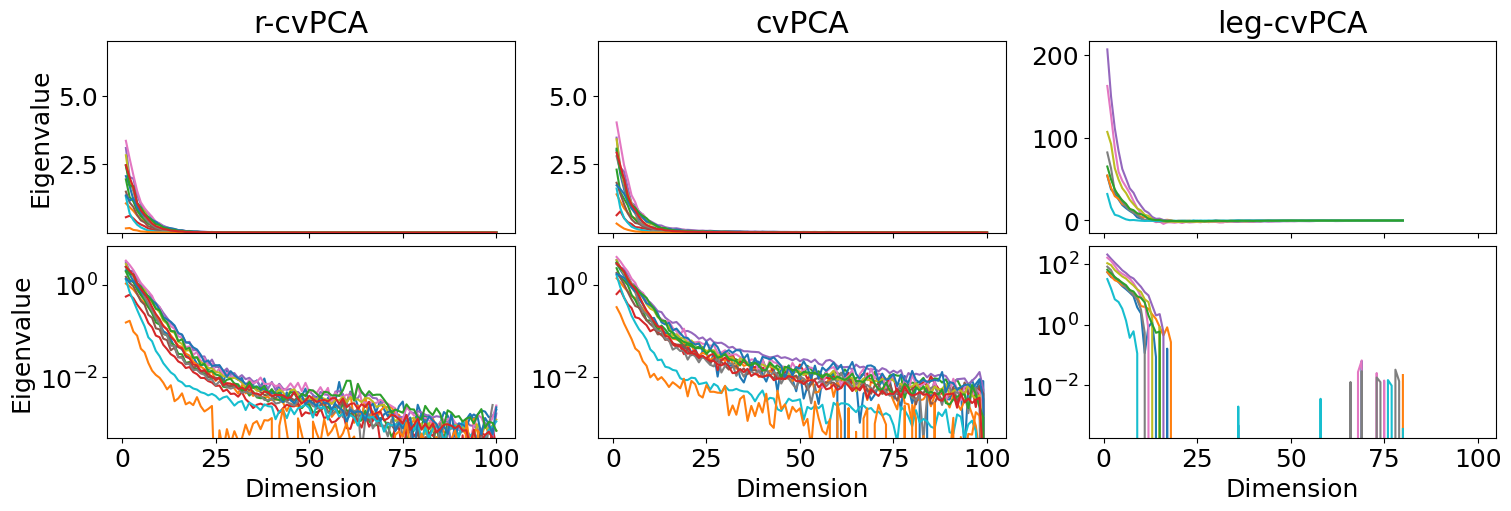

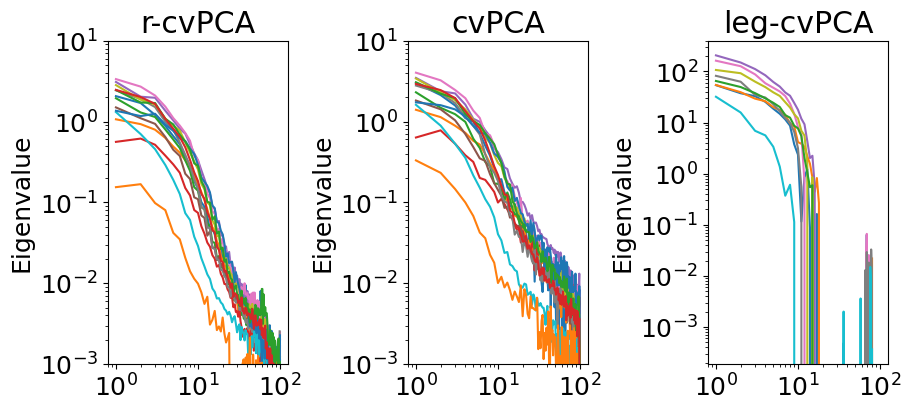

In [3]:
xscale = "linear"
yscale = "linear"

icenter = 0  # center=True (centered)
idims = np.arange(num_bins) + 1
plt.close('all')
fig, ax = plt.subplots(2, 3, figsize=(15, 5), layout="constrained", sharex=True)
ax[0, 0].plot(idims, avg_reg_covariances[icenter].T)
ax[0, 1].plot(idims, avg_org_covariances[icenter].T)
ax[0, 2].plot(idims, avg_saved_leg_covariances[icenter].T)
ax[1, 0].plot(idims, avg_reg_covariances[icenter].T)
ax[1, 1].plot(idims, avg_org_covariances[icenter].T)
ax[1, 2].plot(idims, avg_saved_leg_covariances[icenter].T)
ax[0, 0].set_title("r-cvPCA")
ax[0, 1].set_title("cvPCA")
ax[0, 2].set_title("leg-cvPCA")
ax[0, 0].set_xscale("linear")
ax[0, 1].set_xscale("linear")
ax[0, 2].set_xscale("linear")
ax[0, 0].set_yscale("linear")
ax[0, 1].set_yscale("linear")
ax[0, 2].set_yscale("linear")
ax[1, 0].set_xscale("linear")
ax[1, 1].set_xscale("linear")
ax[1, 2].set_xscale("linear")
ax[1, 0].set_yscale("log")
ax[1, 1].set_yscale("log")
ax[1, 2].set_yscale("log")
ax[1, 0].set_xlabel("Dimension")
ax[1, 1].set_xlabel("Dimension")
ax[1, 2].set_xlabel("Dimension")
ax[0, 0].set_ylabel("Eigenvalue")
ax[1, 0].set_ylabel("Eigenvalue")
ax[0, 0].set_ylim(5e-4, 7e0)
ax[0, 1].set_ylim(5e-4, 7e0)
# ax[0, 2].set_ylim(5e-4, 7e0)
ax[1, 0].set_ylim(5e-4, 7e0)
ax[1, 1].set_ylim(5e-4, 7e0)
# ax[1, 2].set_ylim(5e-4, 7e0)
plt.show()

idims = np.arange(num_bins) + 1
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(9, 4), layout="constrained", sharex=True)
ax[0].plot(idims, avg_reg_covariances[icenter].T)
ax[1].plot(idims, avg_org_covariances[icenter].T)
ax[2].plot(idims, avg_saved_leg_covariances[icenter].T)
ax[0].set_title("r-cvPCA")
ax[1].set_title("cvPCA")
ax[2].set_title("leg-cvPCA")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[0].set_ylabel("Eigenvalue")
ax[1].set_ylabel("Eigenvalue")
ax[2].set_ylabel("Eigenvalue")
ax[0].set_ylim(1e-3, 1e1)
ax[1].set_ylim(1e-3, 1e1)
# ax[2].set_ylim(1e-3, 1e1)
plt.show()

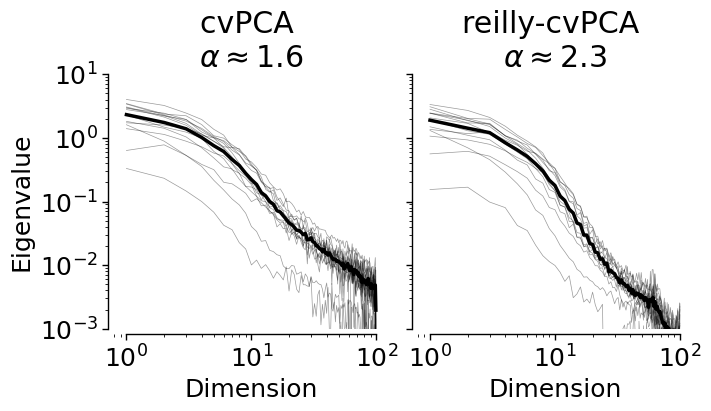

In [4]:
idims = np.arange(num_bins) + 1

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(7, 4), layout="constrained", sharex=True, sharey=True)
ax[0].plot(idims, avg_org_covariances[icenter].T, color="k", alpha=0.4, linewidth=0.5)
ax[1].plot(idims, avg_reg_covariances[icenter].T, color="k", alpha=0.4, linewidth=0.5)
ax[0].plot(idims, np.mean(avg_org_covariances[icenter], axis=0), color="k", linewidth=2.5)
ax[1].plot(idims, np.mean(avg_reg_covariances[icenter], axis=0), color="k", linewidth=2.5)
ax[0].set_title("cvPCA \n" + r"$\alpha \approx 1.6$")
ax[1].set_title("reilly-cvPCA \n" + r"$\alpha \approx 2.3$")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_xlabel("Dimension")
ax[1].set_xlabel("Dimension")
ax[0].set_ylabel("Eigenvalue")
# ax[1].set_ylabel("Eigenvalue")
ax[0].set_ylim(1e-3, 1e1)
ax[1].set_ylim(1e-3, 1e1)
format_spines(
    ax[0],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(idims[0], idims[-1]),
    ybounds=(1e-3, 1e1),
)
format_spines(
    ax[1],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(idims[0], idims[-1]),
    ybounds=(1e-3, 1e1),
)

figure_path = registry.registry_paths.figure_path / "cvpca" / f"compare_cvPCA_rcvPCA"
save_figure(fig, figure_path)
plt.show()

In [14]:
from dimilibi import gaussian_filter
from dimensionality_manuscript.workflows.measure_cvpca import nanmax

# Try to understand weird high-d bump in rcvPCA
session = sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type="oasis"))[0]

# Choose environment
num_per_env = {i: np.sum(session.trial_environment == i) for i in session.environments}
best_env = max(num_per_env, key=num_per_env.get)
best_env_idx = np.where(session.environments == best_env)[0][0]

env_length = session.env_length[0]
dist_edges = np.linspace(0, env_length, num_bins + 1)
population, frame_behavior = registry.get_population(session, spks_type)

trial_folds = cross_validate_trials(session.trial_environment, [1, 1, 1])
data = np.array(population.data[population.idx_neurons][:, population.idx_samples]).T
placefields = [get_placefield(data, frame_behavior, dist_edges, trial_filter=trial_fold, zero_to_nan=True) for trial_fold in trial_folds]
torch_pfs = [torch.tensor(pf.placefield[best_env_idx].T) for pf in placefields]

if any([np.any(pf.count[best_env_idx] == 0) for pf in placefields]):
    bad_locations = [np.where(pf.count[best_env_idx] == 0)[0] for pf in placefields]
    bad_locations = np.unique(np.concatenate(bad_locations))
    good_idx = np.setdiff1d(np.arange(num_bins), bad_locations)
    if not np.all(np.diff(good_idx) == 1):
        print(f"Some placefields have non sequential missing counts at locations: {bad_locations}")
        raise ValueError("Some placefields have no counts in the best environment!")
    else:
        torch_pfs = [torch_pf[:, good_idx] for torch_pf in torch_pfs]

center = True
normalize = True
if normalize:
    _max_neuron = nanmax(torch.concatenate(torch_pfs, dim=1), dim=1, keepdim=True)
    _max_neuron[_max_neuron == 0] = 1
    torch_pfs = [pf / _max_neuron for pf in torch_pfs]

if any([torch.any(torch.isnan(pf)) for pf in torch_pfs]):
    print("Some placefields have NaNs!")
    raise ValueError("Some placefields have NaNs!")

pca_covariances = []
pca_smooth_covariances = []
reg_covariances = []
org_covariances = []
org_smooth_covariances = []
smoothing_widths = []
for ref_fold in range(len(trial_folds)):
    c_repeat_0 = torch_pfs[ref_fold]
    c_repeat_1 = torch_pfs[(ref_fold + 1) % len(trial_folds)]
    c_repeat_2 = torch_pfs[(ref_fold + 2) % len(trial_folds)]

    reg_cvpca = RegularizedCVPCA(center=center)
    reg_cvpca = reg_cvpca.fit_smoothing(c_repeat_0, c_repeat_1, c_repeat_2)
    reg_cvpca = reg_cvpca.fit(c_repeat_0)
    reg_covariance = reg_cvpca.score(c_repeat_1, c_repeat_2)
    reg_covariances.append(reg_covariance)

    cvpca = CVPCA(center=center).fit(c_repeat_0)
    org_covariance_1 = cvpca.score(c_repeat_0, c_repeat_1)
    org_covariance_2 = cvpca.score(c_repeat_0, c_repeat_2)
    org_covariance = np.mean(np.stack([org_covariance_1, org_covariance_2], axis=0), axis=0)
    org_covariances.append(org_covariance)

    c_repeat_0_smooth = gaussian_filter(c_repeat_0, reg_cvpca.smoothing_widths, axis=1)
    c_repeat_1_smooth = gaussian_filter(c_repeat_1, reg_cvpca.smoothing_widths, axis=1)
    c_repeat_2_smooth = gaussian_filter(c_repeat_2, reg_cvpca.smoothing_widths, axis=1)

    cvpca_smooth = CVPCA(center=center).fit(c_repeat_0_smooth)
    org_smooth_covariance_1 = cvpca_smooth.score(c_repeat_0_smooth, c_repeat_1_smooth)
    org_smooth_covariance_2 = cvpca_smooth.score(c_repeat_0_smooth, c_repeat_2_smooth)
    org_smooth_covariance = np.mean(np.stack([org_smooth_covariance_1, org_smooth_covariance_2], axis=0), axis=0)
    org_smooth_covariances.append(org_smooth_covariance)

    pca = PCA(center=center).fit(c_repeat_0)
    pca_covariances.append(pca.get_eigenvalues())

    pca_smooth = PCA(center=center).fit(c_repeat_0_smooth)
    pca_smooth_covariances.append(pca_smooth.get_eigenvalues())

    # Also save smoothing widths for reproducibility
    smoothing_widths.append(reg_cvpca.smoothing_widths)

result = {
    "trial_folds": trial_folds,
    "reg_covariances": np.mean(np.stack(reg_covariances, axis=0), axis=0),
    "org_covariances": np.mean(np.stack(org_covariances, axis=0), axis=0),
    "org_smooth_covariances": np.mean(np.stack(org_smooth_covariances, axis=0), axis=0),
    "pca_covariances": np.mean(np.stack(pca_covariances, axis=0), axis=0),
    "pca_smooth_covariances": np.mean(np.stack(pca_smooth_covariances, axis=0), axis=0),
    "smoothing_widths": np.mean(np.stack(smoothing_widths, axis=0), axis=0),
}

In [15]:
xx = reg_cvpca.pca.get_components()

